In [17]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
from pprint import pprint
import os

from scale.config import load_config
from scale.utils import select_best_lambdas
from scale.training import train
from scale.clustering import calc_clusterings
from scale.search import calc_stability, calc_entropy

# change working directory to the root of the project
cwd = os.getcwd()
if cwd.split("/")[-1] == "notebooks":
    cwd = "/".join(cwd.split("/")[:-1])
    os.chdir(cwd)
    print(f"Changed working directory to {cwd}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare data

In [ ]:
path = "data/merfish_mouse_brain.h5ad"
adata = sc.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 85958 × 483
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'organ_name', 'organ_short', 'category_name', 'category_short', 'division_name', 'division_short', 'structure_name', 'structure_short', 'substructure_name', 'substructure_short', 'ID', 'domain', 'n_counts', 'tot_counts', 'n_genes', 'n_neighbors', 'tot_counts_mean', 'tot_counts_sum'
    var: 'n_cells'
    uns: 'domain_colors'
    obsm: 'blank_genes', 'spatial'

## Setup config

In [4]:
cfg = load_config()
# cfg.distance_set.stop = 25
# cfg.resolution_set.step = 0.1
# cfg.n_repeats = 3

pprint(cfg)

{'batch_col': None,
 'distance_set': {'start': 15, 'step': 5, 'stop': 60},
 'knn_set': {'start': 5, 'step': 5, 'stop': 40},
 'lambda_set': [1e-06,
                5e-06,
                1e-05,
                5e-05,
                0.0001,
                0.0005,
                0.001,
                0.005,
                0.01,
                0.05,
                0.1,
                0.5,
                1,
                5,
                10],
 'lr': 0.01,
 'max_epoch': 500,
 'n_heads': 5,
 'n_hidden': 15,
 'n_repeats': 5,
 'n_sample': None,
 'preprocess': False,
 'repeated_negative_sampling': False,
 'resolution_set': {'start': 0.01, 'step': 0.02, 'stop': 1.2},
 'spatial_graph_method': 'distance',
 'y_aggregated': False}


## Run scale

In [5]:
train(adata, cfg)
select_best_lambdas(adata)

Using device: cuda


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
calc_clusterings(
    adata,
    flavor="igraph",
    n_iterations=2,
)

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating clusterings:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
calc_stability(adata, verbose=True, n_repeat=4, min_dist=15, max_dist=55)
top_results = calc_entropy(
    adata,
    n_levels=2,
    top_n=0.15,
    enforce_dist_change=False,
    min_ncluster_increase=20,
    min_nclusters_start=3,
)
top_results

n_repeat: 4
n_resolutions: 60
n_distances: 9
resolutions: ['0.01', '0.03', '0.05', '0.07', '0.09', '0.11', '0.13', '0.15', '0.17', '0.19', '0.21', '0.23', '0.25', '0.27', '0.29', '0.31', '0.33', '0.35', '0.37', '0.39', '0.41', '0.43', '0.45', '0.47', '0.49', '0.51', '0.53', '0.55', '0.57', '0.59', '0.61', '0.63', '0.65', '0.67', '0.69', '0.71', '0.73', '0.75', '0.77', '0.79', '0.81', '0.83', '0.85', '0.87', '0.89', '0.91', '0.93', '0.95', '0.97', '0.99', '1.01', '1.03', '1.05', '1.07', '1.09', '1.11', '1.13', '1.15', '1.17', '1.19']
distances: ['15', '20', '25', '30', '35', '40', '45', '50', '55']


Calculating stability: 0it [00:00, ?it/s]

Considering 81 settings and 3240 tuples in total.
Retained 11 tuples after filtering


  0%|          | 0/11 [00:00<?, ?it/s]

,avg_entropy,setting_1,setting_0
0,0.038772,leiden_rep_0_dist_45_res_0.03,leiden_rep_0_dist_45_res_0.77


spatial key not found


/tmp/ipykernel_2489742/1514072262.py:10: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=scale_cols, spot_size=20)


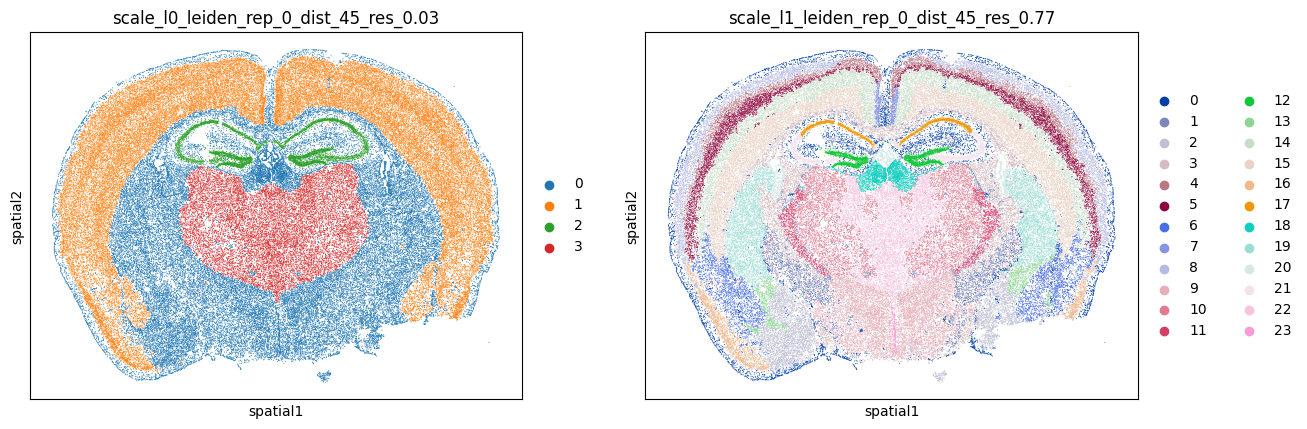

In [21]:
# remove spatial key for scanpy plotting
try:
    del adata.uns["spatial"]
    print("spatial key deleted")
except Exception:
    print("spatial key not found")

# plot spatial domains
scale_cols = [c for c in adata.obs.columns if c.startswith("scale_l")]
sc.pl.spatial(adata, color=scale_cols, spot_size=20)